In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set()
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [446]:
data=pd.read_csv('bbc-train.csv')

In [447]:
def remove_numbers(sentence):
    sentence = re.sub("\d+", "", sentence)
    return sentence

def remove_puntuation(sentence):    
    regex_token= RegexpTokenizer(r'\w+')
    sentence_list=regex_token.tokenize(sentence)
    sentence=" ".join(sentence_list)
    return sentence

def remove_whitespace(sentence):    
    sentence=" ".join(sentence.lower().split())
    return sentence

In [448]:
data['text']=data['text'].apply(remove_numbers)

data['text']=data['text'].apply(remove_puntuation)

data['text']=data['text'].apply(remove_whitespace)

# Visualization

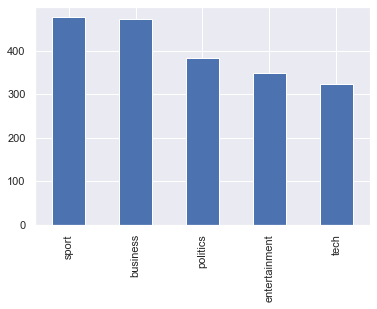

In [449]:
data['category'].value_counts().plot.bar()

(-0.5, 999.5, 299.5, -0.5)

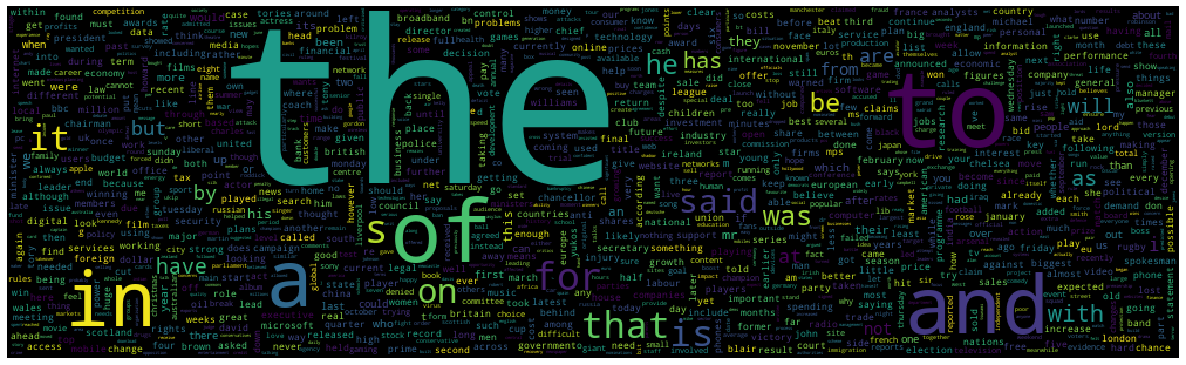

In [450]:
all_words = ' '.join([text for text in data['text']])
all_words = all_words.split()

freq_dist = nltk.FreqDist(all_words)

fig = plt.figure(figsize=(21,16))
ax1 = fig.add_subplot(2,1,1)
wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                      max_words=1628, relative_scaling=1,
                      normalize_plurals=False).generate_from_frequencies(freq_dist)

ax1.imshow(wordcloud)
ax1.axis('off')

In [451]:
# stopwords-to compare text data with and without stopwords

stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
data['clean_text'] = data['text'].apply(lambda x: remove_stopwords(x))

(-0.5, 999.5, 299.5, -0.5)

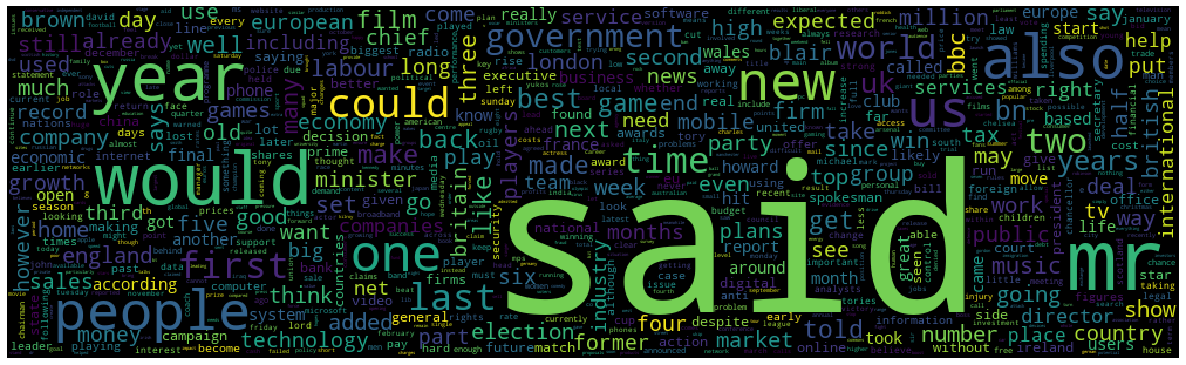

In [452]:
all_words = ' '.join([text for text in data['clean_text']])
all_words = all_words.split()

freq_dist = nltk.FreqDist(all_words)

fig = plt.figure(figsize=(21,16))
ax1 = fig.add_subplot(2,1,1)
wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                      max_words=1628, relative_scaling=1,
                      normalize_plurals=False).generate_from_frequencies(freq_dist)

ax1.imshow(wordcloud)
ax1.axis('off')

# Model

In [479]:
feature=data['clean_text']
label=data['category']

In [499]:
x_train,x_test,y_train,y_test=train_test_split(feature,label,test_size=0.2,random_state=42)

In [500]:
tokenizer=Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

In [501]:
word_index = tokenizer.word_index

In [502]:
len(word_index)

24790

In [503]:
train_sequences=tokenizer.texts_to_sequences(x_train)
valid_sequence=tokenizer.texts_to_sequences(x_test)

In [504]:
train_padded = pad_sequences(train_sequences, maxlen=400, padding='post', truncating='post')
valid_padded = pad_sequences(valid_sequence, maxlen=400, padding='post', truncating='post')

In [505]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)

train_label = np.array(label_tokenizer.texts_to_sequences(y_train))
test_label = np.array(label_tokenizer.texts_to_sequences(y_test))

In [506]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(5000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu'),
    
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 64)          320000    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_32 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_33 (Dense)             (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [507]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [508]:
num_epochs = 15
history = model.fit(train_padded, train_label, epochs=num_epochs, validation_data=(valid_padded, test_label), verbose=2)

Train on 1600 samples, validate on 401 samples
Epoch 1/15
1600/1600 - 19s - loss: 1.5576 - accuracy: 0.3375 - val_loss: 1.1839 - val_accuracy: 0.4090
Epoch 2/15
1600/1600 - 15s - loss: 1.0162 - accuracy: 0.5581 - val_loss: 0.7844 - val_accuracy: 0.6185
Epoch 3/15
1600/1600 - 15s - loss: 0.6372 - accuracy: 0.7819 - val_loss: 0.5580 - val_accuracy: 0.8279
Epoch 4/15
1600/1600 - 15s - loss: 0.3165 - accuracy: 0.9463 - val_loss: 0.4656 - val_accuracy: 0.8903
Epoch 5/15
1600/1600 - 15s - loss: 0.1359 - accuracy: 0.9725 - val_loss: 0.3387 - val_accuracy: 0.9077
Epoch 6/15
1600/1600 - 15s - loss: 0.1129 - accuracy: 0.9744 - val_loss: 0.2315 - val_accuracy: 0.9327
Epoch 7/15
1600/1600 - 15s - loss: 0.0203 - accuracy: 0.9962 - val_loss: 0.2520 - val_accuracy: 0.9252
Epoch 8/15
1600/1600 - 16s - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.3091 - val_accuracy: 0.9202
Epoch 9/15
1600/1600 - 15s - loss: 0.0179 - accuracy: 0.9956 - val_loss: 0.2209 - val_accuracy: 0.9352
Epoch 10/15
1600/1600 - 15

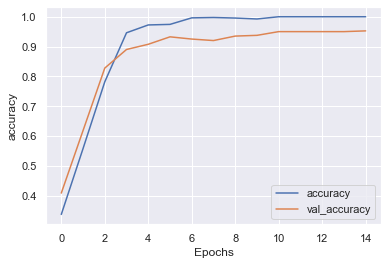

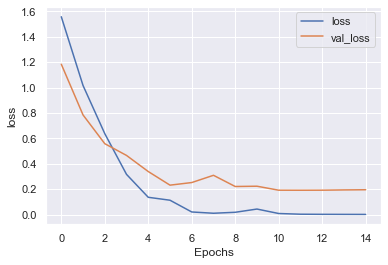

In [510]:
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [511]:
import pickle

# saving
with open('feature_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

# loading
with open('feature_tokenizer.pickle', 'rb') as handle:
    feature_tokenizer = pickle.load(handle)

In [512]:
import pickle

# saving
with open('label_tokenizer.pickle', 'wb') as handle:
    pickle.dump(label_tokenizer, handle)

# loading
with open('label_tokenizer.pickle', 'rb') as handle:
    label_tokenizer = pickle.load(handle)

In [513]:
model.save('model.h5')

In [514]:
model = tf.keras.models.load_model('model.h5')

In [516]:
tst=pd.read_csv('validation.csv')

In [517]:
f1=feature_tokenizer.texts_to_sequences(tst['text'])

In [518]:
l1=label_tokenizer.texts_to_sequences(tst['category'])

In [519]:
p1 = pad_sequences(f1, maxlen=200, padding='post', truncating='post')

In [520]:
pre=model.predict(p1)

In [521]:
res=[]
for i in pre:
    res.append(np.argmax(i))

In [522]:
tst['result']=res

In [523]:
lbl=label_tokenizer.word_index

In [524]:
tst['original_result']=tst['category'].map(lbl)

In [526]:
tst.to_csv('final_result.csv')

In [530]:
correct_prediction=0
wrong_prediction=0

for i in range(len(tst)):
    if tst['result'][i]==tst['original_result'][i]:
        correct_prediction+=1
    else:
        wrong_prediction+=1

In [539]:
score=str((correct_prediction/len(tst))*100)+' %'

In [540]:
score

'96.0 %'